<a href="https://colab.research.google.com/github/prcm066/cancer_detection_example/blob/main/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Detection

## Introduction

The purpose of this project is to desing a classifier that identifies metastatic cancer using scans of pathology tissue microscopy samples.

## Proposed architecture

This architecture proposed is a standard convolutional neural network (CNN) pipeline for binary image classification.

We implement a fairly typical CNN pattern for image analysis tasks, balancing feature extraction with dimensionality reduction and regularization.

### Convolutional Layers

A series of stacked Conv2D layers, employing 3x3 kernels and ReLU activation, extract features sequentially from the input images, with filter counts doubling from 32 to 128. MaxPooling2D layers, with 2x2 pooling windows help with dimensionality reduction.

 A Flatten layer converts to a vector that is feed to a fully connected Dense layer with 128 neurons and ReLU activation.

### Regulatization

A Dropout layer (0.5 rate) is used for regularization.

### Output Layer

A single-neuron Dense output layer with a sigmoid activation function provides the binary classification probability.



## Loading the Data

Here we mount our drive, move files to the environment and unzip.

In [1]:
# !pip install pandas scikit-learn tensorflow


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/structured.zip /content/

In [ ]:
!unzip /content/structured.zip

In [5]:
!cp /content/drive/MyDrive/test.zip /content/sample_data

In [ ]:
!unzip /content/sample_data/test.zip

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC


In [8]:
# !pip install tensorflow-rocm

**Ensure that we are in an accelerated environment (using a single instanfe of Nvidia L4 GPU)**

In [9]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Load the data labels, and point to the folder with the images**

In [12]:

# Configuration
DATA_PATH = '/content/structured/'  # Update this path
BATCH_SIZE = 64
IMAGE_SIZE = (96, 96)
EPOCHS = 10


train_df = pd.read_csv(DATA_PATH + 'train_labels.csv')
train_df['id'] = train_df['id'] + '.tif'  # Add .tif extension to filenames

# Load labels
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv')
train_labels['id'] = train_labels['id'] + '.tif'  # Add file extension



In [13]:
train_df.shape

(220025, 2)

In [14]:
train_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0

In [15]:
# Split data into train and validation sets
# Tis is already done, so we will comment it
# train_df, valid_df = train_test_split(train_labels,
#                                      test_size=0.2,
#                                      random_state=42,
#                                      stratify=train_labels['label'])

In [16]:
# with the split from the snippet above, we copeid the files to their respective folders, 0 or 1.
# This is commented, no need to run it again.

# import shutil

# train_df.apply(lambda x : shutil.copy(DATA_PATH+'train\\' + x['id'], DATA_PATH+'train_labels\\' + str(x['label'])+"\\"+ x['id']),axis=1)
# valid_df.apply(lambda x : shutil.copy(DATA_PATH+'train\\' + x['id'], DATA_PATH+'test_labels\\' + str(x['label'])+"\\"+ x['id']),axis=1)

In [17]:
import os
# print("Train Size: {}".format(len(os.listdir(DATA_PATH + 'train/'))))
# print("Test Size: {}".format(len(os.listdir(DATA_PATH + 'test/'))))


print("Train Size: {}".format( len(os.listdir(DATA_PATH + 'train_labels/0/')) + len(os.listdir(DATA_PATH + 'train_labels/1/'))))
print("Test Size: {}".format(len(os.listdir(DATA_PATH + 'test_labels/0/'))+len(os.listdir(DATA_PATH + 'test_labels/1/'))))

Train Size: 176020
Test Size: 44005


**We review and notice that the sample is slightly imbalanced, however we wont correct for it.**

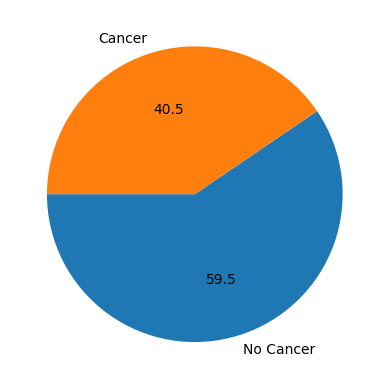

<Figure size 1600x1600 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
labels_count = train_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, autopct='%1.1f')
plt.figure(figsize=(16,16))
plt.show()

We see that the dataset is slightly imbalanced, with CANCER being the minority class.

**We have a look at a few images from both lables in our training folder**

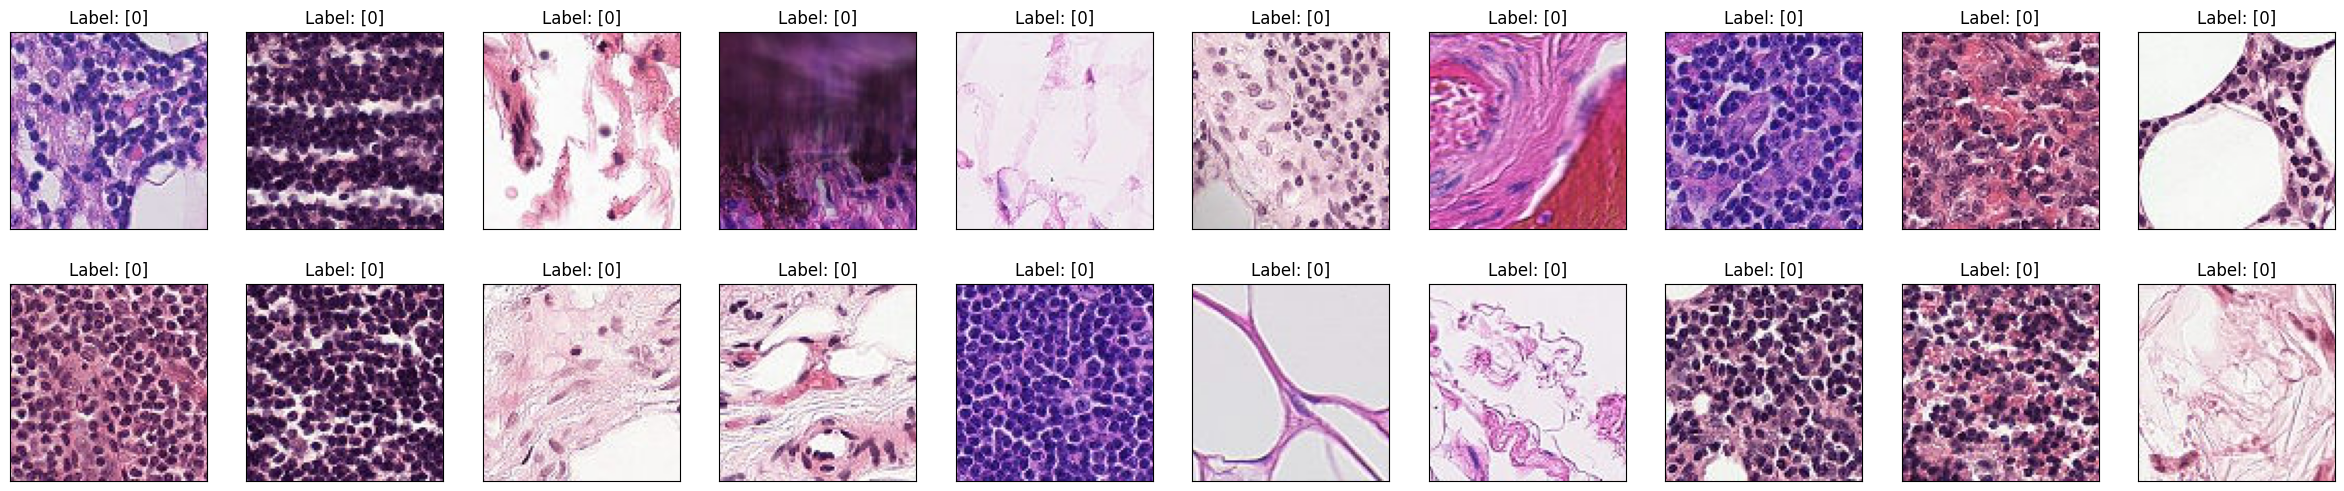

In [19]:
from PIL import Image


fig = plt.figure(figsize=(30, 6))
# display 10 images
train_imgs = os.listdir(DATA_PATH+"train_labels/0/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(DATA_PATH+"train_labels/0/" + img)
    lab = train_df.loc[train_df['id'] == img, 'label'].values
    ax.set_title(f'Label: {lab}')
    plt.imshow(im)
plt.show()

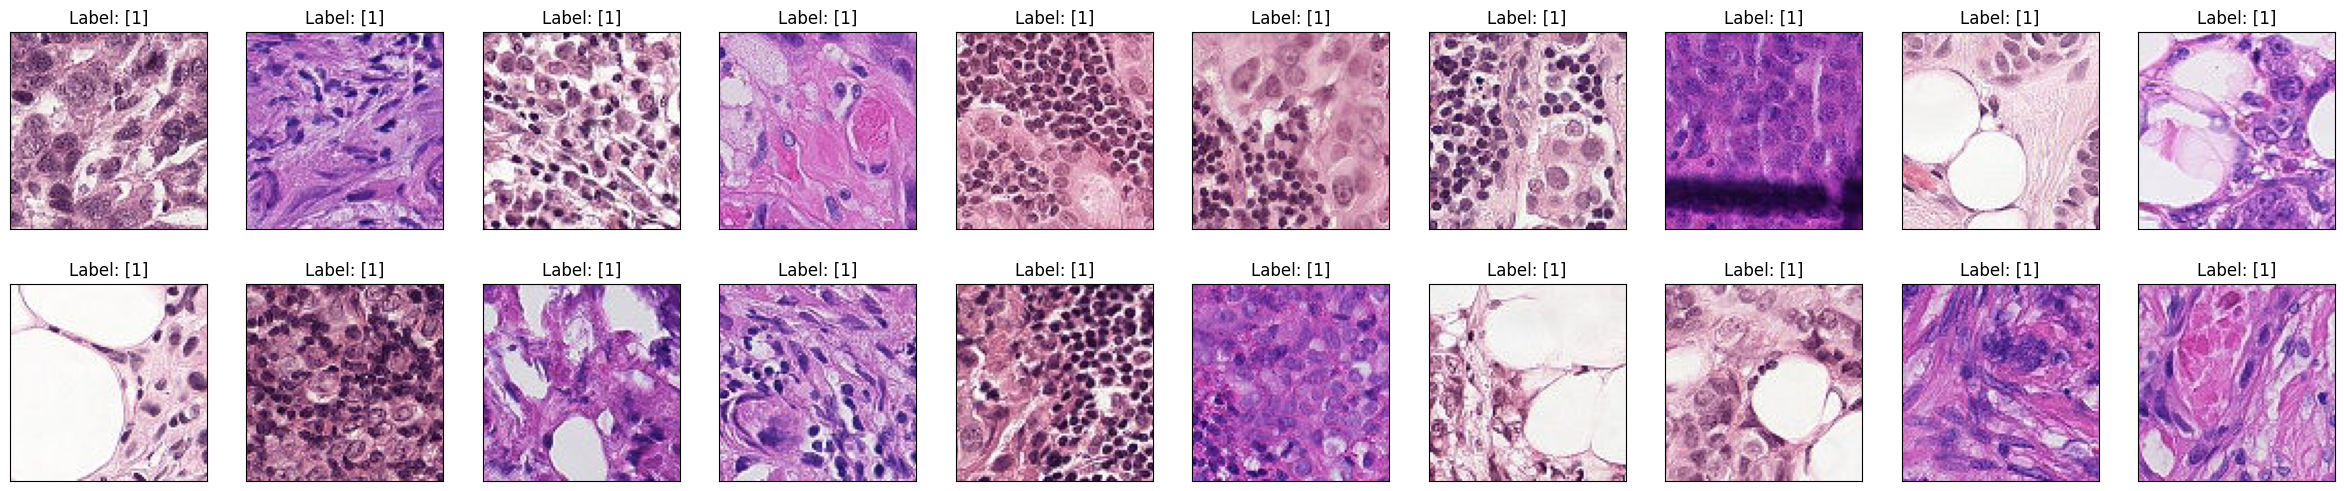

In [20]:

fig = plt.figure(figsize=(30, 6))
# display 10 images
train_imgs = os.listdir(DATA_PATH+"train_labels/1/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(DATA_PATH+"train_labels/1/" + img)
    lab = train_df.loc[train_df['id'] == img, 'label'].values
    ax.set_title(f'Label: {lab}')
    plt.imshow(im)
plt.show()

## Model Building and Training

In this section you will find the model architecture, built layer by layer using keras and the training routine.

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define image dimensions and batch size
img_width, img_height = 96, 96
batch_size = 64

# Pointint to train and validation folders.
# Within each folder we have subfolders 1 and 0,
# where each file is saved according to its label
train_data_dir = DATA_PATH + 'train_labels'
validation_data_dir = DATA_PATH + 'test_labels'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # added validation split for proper validation.
)

# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Load validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Build the CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2)) #Dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10  # Adjust as needed
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the model (optional)
model.save('cancer_detection_model.h5')

#For prediction on test data.
import numpy as np
from tensorflow.keras.preprocessing import image



Found 140817 images belonging to 2 classes.
Found 8800 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 361s 162ms/step - accuracy: 0.7558 - loss: 0.5061 - val_accuracy: 0.7823 - val_loss: 0.4688
Epoch 2/10
   1/2200 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.8281 - loss: 0.3922

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8281 - loss: 0.3922 - val_accuracy: 0.7912 - val_loss: 0.4485
Epoch 3/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 351s 159ms/step - accuracy: 0.8078 - loss: 0.4276 - val_accuracy: 0.8062 - val_loss: 0.4389
Epoch 4/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7656 - loss: 0.4822 - val_accuracy: 0.8033 - val_loss: 0.4456
Epoch 5/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 350s 159ms/step - accuracy: 0.8292 - loss: 0.3896 - val_accuracy: 0.8392 - val_loss: 0.3676
Epoch 6/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8594 - loss: 0.3255 - val_accuracy: 0.8338 - val_loss: 0.3767
Epoch 7/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 351s 160ms/step - accuracy: 0.8447 - loss: 0.3575 - val_accuracy: 0.8298 - val_loss: 0.3870
Epoch 8/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9375 - loss: 0.2516 - val_accuracy: 0.8288 - val_loss: 0.3905
Epoch 9/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 353s 160ms/step - accuracy: 0.8561 - loss: 0.33

In [22]:
model.save('my_model.keras')
!cp /content/my_model.keras /content/drive/MyDrive

## Generate our submission file for Kaggle

In [23]:
test_data_dir = '/content/test'
test_filenames = os.listdir(test_data_dir)
test_images = []
test_ids = []

for filename in test_filenames:
    img_path = os.path.join(test_data_dir, filename)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale
    test_images.append(img_array)
    test_ids.append(filename[:-4])

test_images = np.vstack(test_images)
predictions = model.predict(test_images)
predictions = predictions.flatten()

import pandas as pd
submission = pd.DataFrame({'id': test_ids, 'label': predictions})
submission.to_csv('histopathologic-cancer-detection-submission.csv', index=False)

print("Submission file created.")

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Submission file created.


In [24]:
!cp /content/histopathologic-cancer-detection-submission.csv /content/drive/MyDrive

In [26]:
submission.shape

(57458, 2)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

import os

# Define image dimensions and batch size
img_width, img_height = 96, 96
batch_size = 64

# Pointing to train and validation folders.
# Within each folder we have subfolders 1 and 0,
# where each file is saved according to its label
DATA_PATH = "/content/structured/"
train_data_dir = DATA_PATH + 'train_labels'
validation_data_dir = DATA_PATH + 'test_labels'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20, # Added rotation range
    width_shift_range=0.2, # Added width shift
    height_shift_range=0.2, # Added height shift
    validation_split=0.2
)

# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Load validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Load ResNet50 base model (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers initially
base_model.trainable = False

# Create the new model by adding custom layers on top of the base model
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model (with frozen base model)
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True

# Freeze the first few layers, fine-tune the later ones
fine_tune_at = len(base_model.layers) // 2  # Adjust this value

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the fine-tuned model
model.save('resnet50_fine_tuned.h5')

#Prediction section.
import numpy as np
from tensorflow.keras.preprocessing import image

test_data_dir = DATA_PATH + 'test_data' #Adjust as needed.
test_filenames = os.listdir(test_data_dir)
test_images = []
test_ids = []

for filename in test_filenames:
    img_path = os.path.join(test_data_dir, filename)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale
    test_images.append(img_array)
    test_ids.append(filename[:-4]) #remove .png

test_images = np.vstack(test_images)
predictions = model.predict(test_images)
predictions = predictions.flatten()

import pandas as pd
submission = pd.DataFrame({'id': test_ids, 'label': predictions})
submission.to_csv('submission_resnet.csv', index=False)

print("Resnet Submission file created.")

In [ ]:
model.save('resnet50_fine_tuned.keras')
!cp /content/resnet50_fine_tuned.keras /content/drive/MyDrive

!cp /content/submission_resnet.csv /content/drive/MyDrive